## Khai báo thư viện

In [ ]:
#Lecturer: Phat Vo

!pip uninstall tensorflow -y #xóa phiên bản tensorflow hiện tại (1.15) của google colab
!pip install tensorflow-gpu==2.0 #cài đặt tensorflow bản GPU 2.0

#sau khi chạy xong cell, click "Restart runtime" rồi chạy cell tiếp theo

Uninstalling tensorflow-1.15.0:
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 46.5MB/s 
     |████████████████████████████████| 450kB 54.7MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.2 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [ ]:
import tensorflow as tf
print(tf.__version__) #kiểm tra phiên bản của tensorflow (2.0)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

2.0.0


## Nạp dữ liệu

Ta sẽ dùng tập dữ liệu <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> trên  Kaggle.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True) #tải file về và giải nén
print (path_to_zip)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered') #gán đường dẫn trỏ đến file vừa tải

68608000/68606236 [==============================] - 1s 0us/step
/root/.keras/datasets/cats_and_dogs.zip


Tập dữ liệu sẽ có cấu trúc như sau:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Sau khi giải nén, ta sẽ gán đường dẫn cho các tập huấn luyện, kiểm thử.

In [ ]:
#đặt đường dẫn đến thư mục train, validation
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
#đặt đường dẫn đến thư mục chó, mèo cụ thể
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures


### Khám phá dữ liệu

Kiểm tra số hình ảnh chó mèo, kích thước của các hình có đồng nhất hay không

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir)) #kiểm tra số hình ảnh mèo trong thư mục train
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [ ]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [ ]:
from PIL import Image #thư viện giúp load hình ảnh

im = Image.open(os.path.join(train_cats_dir, 'cat.10.jpg'))
width, height = im.size #gán kích thước của ảnh vào 2 biến width, height
print (width, height)

im = Image.open(os.path.join(train_cats_dir, 'cat.11.jpg'))
width, height = im.size
print (width, height)

489 499
431 410


Thiết lập sẵn các siêu tham số để tiền huấn luyện và huấn luyện

In [ ]:
batch_size = 128
epochs = 50

#thiết lập kích thước mà chúng ta muốn resize ảnh
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Chuẩn bị dữ liệu


`ImageDataGenerator` của `tf.keras` sẽ giúp chúng ta trong vấn đề:
1. Đọc hình ảnh từ thư mục.
2. Chuyển đổi hình ảnh sang tensor.
3. Scale dữ liệu về giới hạn [0,1].
4. Chỉnh sửa kích cỡ để đồng nhất dữ liệu.

Xem thêm: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator cho tập train, rescale ảnh về giới hạn [0,1]
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator cho tập validation

Sau khi định nghĩa Generator, ta sẽ tiến hành đọc hình ảnh, scale, resize,... bằng `flow_from_directory`.

In [ ]:
#từ đường dẫn train_dir, chúng ta sẽ resize ảnh về (IMG_HEIGHT, IMG_WIDTH) (150 x 150), chia tập train ngẫu nhiên (shuffle) theo batch=64 ảnh. 
#Thiết lập chế độ phân lớp là binary.
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           shuffle=True,
                                                           batch_size=batch_size,
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=batch_size,
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Biểu diễn hình ảnh bằng `matplotlib`

In [ ]:
sample_training_images, _ = next(train_data_gen)

Hàm `next` trả về một batch của tập dữ liệu. Kết quả trả về dưới dạng `(x_train, y_train)`, với x_train là đặc trưng huấn luyện, y_train là nhãn. `_` để bỏ qua nhãn và biểu diễn hình ảnh.

In [ ]:
# Biểu diễn các hình dưới dạng lưới 1 dòng, 5 cột.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout() #automatically adjusts subplot params so that the subplot(s) fits in to the figure area
    plt.show()

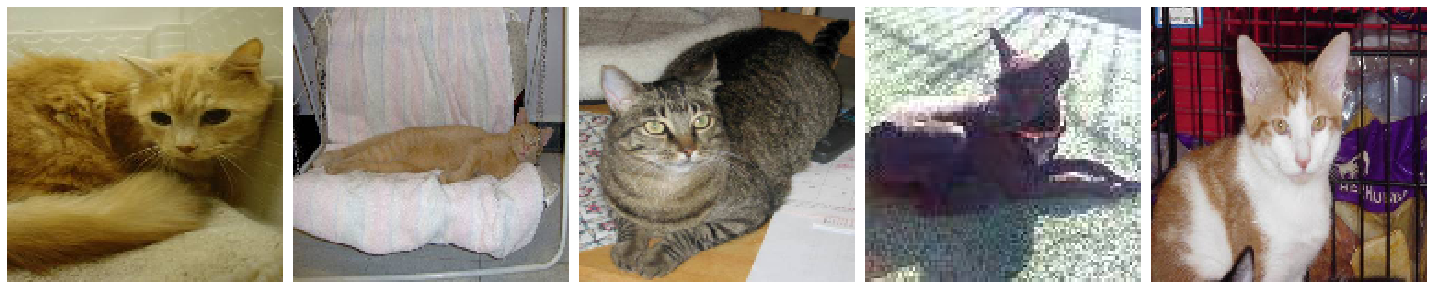

In [ ]:
plotImages(sample_training_images[:5])

## Khởi tạo mô hình

Hãy tạo mô hình gồm 3 khối tích chập, số filter, kích cỡ tuỳ chọn, mỗi khối đều dùng phép đệm giữ nguyên (same padding). Tiếp theo là một tầng kết nối đầy đủ với 512 đơn vị ẩn, hàm kích hoạt là `...`. Đầu ra là xác suất cho bài toán phân loại nhị phâm bằng hàm `...`

In [ ]:
#Cell dùng để luyện tập, hãy suy nghĩ và điền vào chỗ trống trước khi xem kết quả bên dưới

model = Sequential([
    Conv2D(..., ..., padding='...', activation='...', input_shape=(..., ... ,...)),
    ...(), #pool
    Conv2D(..., ..., padding='...', activation='...'),
    ...(),
    Conv2D(..., ..., padding='...', activation='...'),
    ...(),
    ...(), #convert to right format before running FCNN
    Dense(..., activation='...'),
    Dense(..., activation='...')
])

In [ ]:
model = Sequential([
    #từ input có kích thước 150 x 150, ảnh màu (có 3 kênh RGB), ta dùng phép đệm "same" (đảm bảo kích thước input = output) 
    #cho qua 16 kernel có kích thước 3 x 3, rồi dùng hàm ReLU để ép giá vị về khoảng [0, +infinity]
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)), 
    
    #dùng hàm gộp giúp mô hình trở nên bền vững trước các thay đổi nhỏ ở đầu vào hơn. Kích thước gộp default là 2 x 2
    MaxPooling2D(),

    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    #Flatten để đưa dữ liệu từ dạng tensor 2 chiều thành tensor 1 chiều để phù hợp với input của tầng Dense (aka tầng fully-connected)
    Flatten(),

    #Tầng dense có 512 đơn vị ẩn. Sau khi tính toán sẽ được đưa qua hàm ReLU để ép giá trị về khoảng [0, +infinity]
    Dense(512, activation='relu'),

    #Tầng dense cuối cùng có 1 đơn vị ẩn, cho qua hàm sigmoid để trả về kết quả thuộc [0,1]
    Dense(1, activation='sigmoid')
])

### Biên dịch mô hình

Ta dùng bộ tối ưu hoá Adam, hàm mất mát là `...`. Để xem độ chính xác huấn luyện và kiểm thử, ta thêm vào đối số `metric`. Ở đây `metric` có thể là ...

In [ ]:
#Cell luyện tập

model.compile(optimizer='adam',
              loss='...',
              metrics=['...'])

In [ ]:
model.compile(optimizer='adam', #ta dùng biến thể adam của thuật toán trượt gradient
              loss='binary_crossentropy', #hàm loss dùng cho bài toán phân loại 2 lớp
              metrics=['accuracy']) #thang đo mà ta muốn theo dõi

### Tổng kết mô hình

Để xem thông tin của các tầng trong mô hình, ta dùng lệnh ` summary`:

In [ ]:
model.summary()

### Huấn luyện mô hình

Dùng `fit_generator` của lớp `ImageDataGenerator` để huấn luyện mạng

In [ ]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

### Biễu diễn kết quả huấn luyện

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Quá khớp (Overfitting)

Trong đồ thị trên, độ chính xác huấn luyện tăng dần theo thời gian nhưng độ chính xác kiểm thử lại dừng ở mức 70%. Đây là dấu hiệu của sự *quá khớp*.

Với một số lượng nhỏ mẫu huấn luyện, đôi lúc mô hình sẽ học cả nhiễu hay những chi tiết không mong muốn từ các mẫu và sẽ ảnh hưởng xấu đến hiệu quả khi dự đoán các mẫu mới. Có rất nhiều cách để ngăn chặn việc này như cơ chế `tắt ngẫu nhiên (dropout)`, `tăng cường dữ liệu (data augmentation)`,...

## Tăng cường dữ liệu

Tăng cường dữ liệu là cách sử dụng các phương pháp biến đổi nhỏ, ngẫu nhiên để biến đỗi mẫu dữ liệu gốc.

### Tăng cường và hiển thị dữ liệu

### Lật theo trục hoành `horizontal_flip`

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

In [ ]:
train_data_gen[15][0][0].shape

Lấy một mẫu từ tập huấn luyện, lặp lại việc tăng cường dữ liệu (lật theo trục hoành) 5 lần.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)] #batch -> 0:sample, 1: label -> samples data 3d
plotImages(augmented_images)

### Xoay ảnh ngẫu nhiên

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Phóng to ảnh ngẫu nhiên

Phóng to ảnh ngẫu nhiên, tối đa 50%

In [ ]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))



In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Kết hợp tất cả lại 

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Tạo generator cho tập kiểm thử

Lưu ý ta chỉ tăng cường dữ liệu cho tập huấn luyện. Tập kiểm thử này sẽ được giữ nguyên.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

## Cơ chế tắt ngẫu nhiên

Một kĩ thuật khác để giảm quá khớp là "tắt ngẫu nhiên". Đây là một dạng của cơ chế *kiểm soát hoá (regularization)*.
Đây áp dụng dropout, nó sẽ ngẫu nhiên gán 0 cho một số đơn vị ẩn. 
Dropout 0.1 tức là gán 0 cho 10% số đơn vị ẩn.

## Tạo mạng mới với cơ chế tắt ngẫu nhiên

In [ ]:
model_new = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.1),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.1),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.1),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Biên dịch mô hình

In [ ]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

### Huấn luyện mô hình

In [ ]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

### Biểu diễn kết quả huấn luyện


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()